## Compare oil type volumes by vessel 

In [1]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

# import functions for querying DOE and monte-carlo dataframes
from monte_carlo_utils import get_montecarlo_oil_byfac, get_montecarlo_oil
from monte_carlo_utils import get_oil_classification, get_DOE_df
from monte_carlo_utils import get_DOE_quantity_byfac, get_DOE_quantity

In [2]:
#~~~~~  User inputs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'
DOE_2021_xlsx = DOE_dir/'MuellerTrans_5-26-21.xlsx'

# Facility names and lat/lon information file
facilities_xlsx = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'Oil_Transfer_Facilities.xlsx'
)

# 10,000 monte carlo spills
monte_carlo_csv = Path(
    '/Users/rmueller/Data/MIDOSS/monte_carlo/'
    'SalishSeaOilSpills_fixbarge_10000_1.csv'
)

# Oil Attribution file 
oil_attribution_file = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'oil_attribution.yaml'
)

# location of output excel spreadsheets
output_directory = Path(
    '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
)
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

# location of output .tex documents for writing tables to file
tex_dir = Path(
    '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/'
    'Documents/Publications/MIDOSS/MIDOSS_MuellerEtAl_paper1/Methods/'
    'notes/python_generated_tables')

data_types = ['total_gallons', 'fraction_of_total', 'number_of_transfers']
# oil types used in our study
oil_types = [
    'ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 'Other'
]
oil_colors = [
    'orange', 'saddlebrown','darkslateblue',
    'steelblue','slateblue','olive',
    'darkgoldenrod'
]
# create a color dictionary for oil types to us in pie charts
colordict={}
for l,c in zip(oil_types,oil_colors):
    colordict[l]=c

# The precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# unit conversions
gal2m3 = 0.00378541

### Load data files 

In [3]:
# Oil Attribution File
with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# Facility information 
facdf = pandas.read_excel(
    facilities_xlsx,
    sheet_name = 'Washington'
)

# New method converts DOE facility names to monte-carlo facility names
# in `get_DOE_df` function of `monte_carlo_utils.py`, so I now use the 
# monte_carlo names uniformly to query both DOE and monte-carlo facilities
facility_names = oil_attrs['categories']['US_origin_destination']

### Check to make sure that I got the DOE facility names right

In [4]:
facdf.head(1)

,FSID,FacilityName,FacilityAlternateName,FacilityDOEName,ClassType,EcologyProgram,FacilityType,OilProducts,FacilitySiteLink,DockLatNumber,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,13,BP Cherry Point Refinery,BP CHERRY POINT REFINERY,BP Cherry Point Refinery,Class 1 Facility,"Spills Prevention, Preparedness, and Response",REFINERY,"CRUDE OIL,DIESEL/MARINE GAS OIL,AVIATION GASOL...",https://apps.ecology.wa.gov/facilitysite/Repor...,48.86111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# load DOE data such that the three terminals that are grouped in our
# origin-destination analysis are re-named to the terminal that they
# are grouped with in our analysis. 
df = get_DOE_df(DOE_2018_xlsx, facilities_xlsx, group = 'yes')

In [7]:
# sort by deliverer and receiver
df_del = df.loc[
    df.DelivererTypeDescription == 'Facility',
    ['Deliverer','TransferQtyInGallon']
].groupby('Deliverer').sum().sort_values(by='TransferQtyInGallon', ascending=False)
df_del.reset_index(inplace=True)
df_del = df_del.rename(columns={'Deliverer':'Facility_names'})
df_rec = df.loc[
    df.ReceiverTypeDescription == 'Facility',
    ['Receiver','TransferQtyInGallon']
].groupby('Receiver').sum().sort_values(by='TransferQtyInGallon', ascending=False)
df_rec.reset_index(inplace=True)
df_rec = df_rec.rename(columns={'Receiver':'Facility_names'})

In [8]:
doe_del_facs = df_del['Facility_names'].to_list()
doe_rec_facs = df_rec['Facility_names'].to_list()
print(f'List of {len(doe_del_facs)} facilities that deliver cargo but do not recieve cargo')
print('--------------------------------------------------------------')
length=0
for facility in doe_del_facs:
    if facility not in doe_rec_facs:
        print(facility)
        length +=1
       
    
print('')
print(f'List of {len(doe_rec_facs)} facilities that receive cargo but do not deliver cargo')        
print('--------------------------------------------------------------')
for facility in doe_rec_facs:
    if facility not in doe_del_facs:
        print(facility)
        length+=1

List of 35 facilities that deliver cargo but do not recieve cargo
--------------------------------------------------------------
Pacific Ethanol
Maxum - Fairhaven Terminal
Ballard Oil Co.
Covich Williams Co Inc
PetroCard Inc - Westport Fuel Dock
Pacific Northwest Terminals Inc
BP West Coast Arco Seattle Terminal
SDS Lumber
Port Angeles Marine Inc - Port Angeles Boat Haven
Pacific Functional Fluids, LLC
Jubitz (Vancouver Oil)
Harbor Marine Fuels, Squalicum
Port of Port Angeles - John Wayne Marina
Connell Oil Inc
Nelson Petroleum

List of 45 facilities that receive cargo but do not deliver cargo
--------------------------------------------------------------
Tidewater Umatilla Terminal
Naval Air Station Whidbey Island (NASWI)
REG Grays Harbor, LLC
Shell
Seaport Seattle Terminal 
Andeavor Port Angeles
Alon Point Wells
EVER LYRIC
CHS PRIMELAND / MEGREGOR 
NEW ENDEAVOR
CHS PRIMELAND
Arctic Titan
Ross Lake Resort
MY ICE BEAR
Island Scout
Barge B-30
Terrapin
Tidewater Environmental Services
Em

In [9]:
# merge the two lists 
all_facilities = pandas.merge(
    left=pandas.DataFrame(doe_del_facs).rename(columns={0:'Facility_names'}), 
    right=pandas.DataFrame(doe_rec_facs).rename(columns={0:'Facility_names'}),
    how='outer',
    on='Facility_names'
)
all_facilities = pandas.merge(
    left = all_facilities,
    right = df_del,
    how='left',
    on = 'Facility_names'
)
all_facilities = pandas.merge(
    left = all_facilities,
    right = df_rec,
    how='left',
    on = 'Facility_names'
).fillna(0)
all_facilities = all_facilities.rename(
    columns={
        'TransferQtyInGallon_x':'TransferOutGallons',
        'TransferQtyInGallon_y':'TransferInGallons'}
)
all_facilities['TransferTotalGallons'] = (
    all_facilities['TransferOutGallons'] + \
    all_facilities['TransferInGallons']
)
all_facilities['TransferPercent'] = (
    100 * all_facilities['TransferTotalGallons']/\
    all_facilities['TransferTotalGallons'].sum()
)

all_facilities.loc[
    all_facilities['Facility_names'].isin(facility_names),
    'In Monte Carlo?'] = 'yes'
all_facilities.loc[
    ~all_facilities['Facility_names'].isin(facility_names),
    'In Monte Carlo?'] = '--'
percent_represented = all_facilities.loc[
    all_facilities['In Monte Carlo?'] == 'yes',
    ['TransferPercent']
].sum()
print(f'{percent_represented.item():.2f}% of WA oil cargo transfers' 
       ' occurs at the marine terminals represented in our study'
)
all_facilities.to_latex(buf=tex_dir/'monte_carlo.tex',float_format="%.2e",index=False)
# all_facilities.to_latex(buf=tex_dir/'monte_carlo.tex',
#                         formatters={0:'s',
#                                     1:'.2e',
#                                     2:'.2e',
#                                     3:'.2e',
#                                     4:'3.0f',
#                                     5:'s'},
#                         index=False
#                        )

all_facilities.sort_values(by='TransferTotalGallons', ascending=False)

98.52% of WA oil cargo transfers occurs at the marine terminals represented in our study


,Facility_names,TransferOutGallons,TransferInGallons,TransferTotalGallons,TransferPercent,In Monte Carlo?
0,BP Cherry Point Refinery,1.481203e+09,2.081266e+09,3.562470e+09,34.839781,yes
3,Shell Puget Sound Refinery,6.647760e+08,1.332554e+09,1.997330e+09,19.533229,yes
1,Marathon Anacortes Refinery (formerly Tesoro),7.101696e+08,5.718167e+08,1.281986e+09,12.537405,yes
2,Phillips 66 Ferndale Refinery,6.750366e+08,5.775084e+08,1.252545e+09,12.249478,yes
5,SeaPort Sound Terminal,2.043491e+08,1.820779e+08,3.864269e+08,3.779128,yes
4,U.S. Oil & Refining,2.214726e+08,7.415759e+07,2.956302e+08,2.891166,yes
6,Alon Asphalt Company (Paramount Petroleum),1.515102e+08,1.425777e+08,2.940879e+08,2.876083,yes
8,Tidewater Snake River Terminal,6.693131e+07,1.805777e+08,2.475090e+08,2.420557,yes
7,Kinder Morgan Liquids Terminal - Harbor Island,1.310983e+08,1.076320e+08,2.387303e+08,2.334704,yes
14,Tesoro Pasco Terminal,4.620000e+06,1.030427e+08,1.076627e+08,1.052906,yes


In [ ]:
missing_facilities=all_facilities.loc[
    ~all_facilities['Facility_names'].isin(facility_names)
].sort_values(by='TransferPercent', ascending=False)

missing_facilities.head()

### Get DOE and monte-carlo attributions (both facility transfers and all transfers)

In [12]:
#--------------------------------------------------------------------------------
# Sum DOE oil transfers to/from facilities by oil and vessel types
#--------------------------------------------------------------------------------
print('Getting DOE volume transfers by Salish Sea facilities')
exports, imports, combined = get_DOE_quantity_byfac(
    DOE_2018_xlsx, facilities_xlsx, facilities='selected'
)

#--------------------------------------------------------------------------------
# Sum all DOE oil transfers by oil and vessel types
#--------------------------------------------------------------------------------
print('Getting all DOE volume transfers for WA')
exports_all, imports_all, combined_all = get_DOE_quantity(DOE_2018_xlsx, facilities_xlsx)

#--------------------------------------------------------------------------------
# Sum monte-carlo tank capacities in spills file by vessel and oil types
# to estimate oil type traffic based only on transfers to/from marine facilities 
#--------------------------------------------------------------------------------
mc_export = {}
mc_import = {}
mc_allUS = {}
for idx,vessel in enumerate(["tanker","atb","barge"]):
    # calculate total cargo_capacity by vessel type and oil type
    print(f'Getting monte-carlo {vessel} exports/imports to/from WA marine terminals')
    mc_export[vessel], mc_import[vessel] = get_montecarlo_oil_byfac(
        vessel, 
        monte_carlo_csv
    )
    # calculate total cargo_capacity by vessel type and oil type
    print(f'Getting monte-carlo {vessel} representation of US oil transport')
    mc_allUS[vessel] = get_montecarlo_oil(
        vessel, 
        monte_carlo_csv
    )

# Add entries for oil types that may not be in monte-carlo file
# so that the DOE and monte-carlo information in the same format
# I intend to eventually put this will go into monte_carlo_utils.py 
# script if using a key-value pair for both information sources 
# will ensure that I don't make an ordering mis-match mistake
for vessel in ["tanker","atb","barge"]: 
    mc_export[vessel] = dict(mc_export[vessel])
    mc_allUS[vessel] = dict(mc_allUS[vessel])
    # Add oil types missing in US traffic 
    # e.g. Dilbit is missing in tanker, ANS is missing in ATBs
    for oil in oil_types: 
        if oil not in mc_export[vessel].keys():
            mc_export[vessel][oil] = 0.0
            mc_allUS[vessel][oil] = 0.0

Getting DOE volume transfers by Salish Sea facilities
this code note yet tests with fac_xls as input
this code note yet tests with fac_xls as input
Tallying atb quantities
Tallying barge quantities
Tallying tanker quantities
Getting all DOE volume transfers for WA
this code note yet tests with fac_xls as input
Tallying atb quantities
Tallying barge quantities
Tallying tanker quantities
Getting monte-carlo tanker exports/imports to/from WA marine terminals
Getting monte-carlo tanker representation of US oil transport
Getting monte-carlo atb exports/imports to/from WA marine terminals
Getting monte-carlo atb representation of US oil transport
Getting monte-carlo barge exports/imports to/from WA marine terminals
Getting monte-carlo barge representation of US oil transport


### Check: Is there dilbit in monte-carlo

In [13]:
mcdf = pandas.read_csv(monte_carlo_csv)
mcdf.groupby(
    'Lagrangian_template'
).cargo_capacity.sum()

Lagrangian_template
Lagrangian_akns.dat      6.297207e+09
Lagrangian_bunker.dat    2.501182e+10
Lagrangian_diesel.dat    3.754784e+10
Lagrangian_dilbit.dat    1.519596e+08
Lagrangian_gas.dat       3.436718e+09
Lagrangian_jet.dat       1.280186e+09
Lagrangian_other.dat     2.511821e+09
Name: cargo_capacity, dtype: float64

In [14]:
### Dilbit isn't showing up in terminal transfer plots (below).  ID source(s)
dilbit = mcdf.loc[
    (mcdf.Lagrangian_template == 'Lagrangian_dilbit.dat'),
    ['vessel_origin','vessel_dest']
]
dilbit.shape

(4, 2)

In [15]:
dilbit

,vessel_origin,vessel_dest
1964,Westridge Marine Terminal,US
2608,Pacific,Westridge Marine Terminal
3265,Westridge Marine Terminal,Pacific
6758,Westridge Marine Terminal,Canada


### Create: Dictionary for percentage values and comparison

In [16]:
percent_oil_df = {}
percentages = {}
for idx,vessel in enumerate(["tanker", "atb", "barge"]):
    percentages = {'DOE': [], 'monte-carlo': [], 'DOE_minus_monte-carlo': []}
    percentages['DOE']  = [
       100*exports[vessel][oil]/sum(exports[vessel].values()) for oil in exports[vessel].keys()
    ]
    percentages['monte-carlo']  = [
       100*mc_export[vessel][oil]/sum(mc_export[vessel].values()) for oil in exports[vessel].keys()
    ]
    percentages['DOE_minus_monte-carlo'] = [
        percentages['DOE'][idx] - percentages['monte-carlo'][idx] for idx in range(len(percentages['DOE']))
    ] 
    percent_oil_df[vessel] = pandas.DataFrame(
        data=percentages,
        index=exports[vessel].keys()
    ).rename_axis(index=f'{vessel} export')

In [17]:
def calc_percent_difference(DOE_dict, MC_dict):
    """
    Inputs: dictionaries created by get_montecarlo_oil_byfac, 
         get_montecarlo_oil, get_DOE_quantity, get_DOE_quantity_byfac
    Outputs: Dictionary organized by vessel type with columns corresponding to 
        oil_type percentages for DOE, monte-carlo csv and difference
    """
    percent_oil_df = {}
    percentages = {}
    for idx,vessel in enumerate(["tanker", "atb", "barge"]):
        percentages = {
            'DOE': [], 
            'monte-carlo': [], 
            'DOE_minus_monte-carlo': []
        }
        percentages['DOE']  = [
           100*DOE_dict[vessel][oil]/sum(DOE_dict[vessel].values()) 
            for oil in DOE_dict[vessel].keys()
        ]
        # note: I'm using the DOE dictionary to loop through oil types 
        # so that the order of the output lists are identical 
        percentages['monte-carlo']  = [
           100*MC_dict[vessel][oil]/\
            sum(MC_dict[vessel].values()) 
            for oil in DOE_dict[vessel].keys()
        ]
        percentages['DOE_minus_monte-carlo'] = [
            percentages['DOE'][idx] - \
            percentages['monte-carlo'][idx] \
            for idx in range(len(percentages['DOE']))
        ] 
        percent_oil_df[vessel] = pandas.DataFrame(
            data=percentages,
            index=exports[vessel].keys()
        ).rename_axis(index=f'{vessel} export')
        
    return percent_oil_df

---
## Plot monte carlo and DOE representation of oil exports by vessel types
---

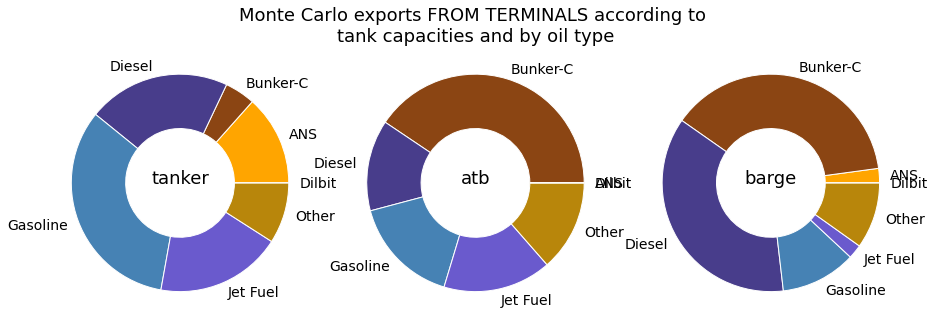

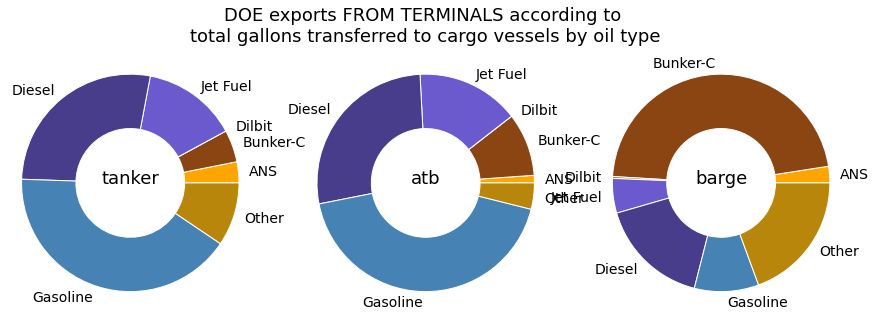

In [18]:
#--------------------------------------------------------------------------------
# Plot monte-carlo representation of oil export 
#--------------------------------------------------------------------------------
# Get cargo exports by vessel type and add up cargo_capacities by oil type
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge"]):

    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('Monte Carlo exports FROM TERMINALS according to \n'
             'tank capacities and by oil type'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        mc_export[vessel].values(), 
        labels = mc_export[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'monte_carlo_oil_exports_v2')
#--------------------------------------------------------------------------------
## Plot department of ecology volume transfers from marine terminals by oil types
#--------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('DOE exports FROM TERMINALS according to \n'
             'total gallons transferred to cargo vessels by oil type'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        exports[vessel].values(), 
        # commented out version 
#         labels = [
#             f'{oil}({100*exports["atb"][oil]/sum(exports["atb"].values()):0.1f}%)' for oil in exports['atb'].keys()
#         ],
        labels = exports[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        # commented out version parses label to get oil name for color dictionary
        #pie_wedge.set_facecolor(colordict[pie_wedge.get_label().split('(')[0]])
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil_exports_byterminals.png')

### Print: Percentages relating to differences in exports from marine terminals
(correspongind to above graphic)

In [19]:
percent_test = calc_percent_difference(exports, mc_export)
percent_test

{'tanker':                      DOE  monte-carlo  DOE_minus_monte-carlo
 tanker export                                               
 ANS             3.126748    13.431827             -10.305079
 Bunker-C        4.793320     4.528030               0.265290
 Dilbit          0.000000     0.000000               0.000000
 Jet Fuel       14.127357    18.760461              -4.633104
 Diesel         27.416191    21.196383               6.219808
 Gasoline       41.097609    33.027237               8.070371
 Other           9.438775     9.056060               0.382714,
 'atb':                   DOE  monte-carlo  DOE_minus_monte-carlo
 atb export                                               
 ANS          1.119410     0.000000               1.119410
 Bunker-C     9.393796    40.582420             -31.188623
 Dilbit       0.000000     0.000000               0.000000
 Jet Fuel    15.320998    16.105545              -0.784547
 Diesel      27.265108    13.557749              13.707359
 Gasoline  

## Take aways:
- We do tanker exports reasonably well. :-) 
- We do jet fuel reasonably well for all vessel
- We tend to get Bunker-C right for tanker and barges
- We show Bunker as the dominant ATB export where DOE shows gasoline (We under attribute gasoline and over-attribute bunker-C in atbs)
- We show less Bunker-C in barge export and more deisel than DOE barge export 

Plausible explanations: 
- Our vessel join method is biased in which terminals it captures. 
- Barge tugs may be attributed as ATB tugs and visa versa (hence, attributed differently in our attribution than in DOE data)     

---
## Plot representations of US oil transport according to our monte carlo and DOE oil transfers 
---

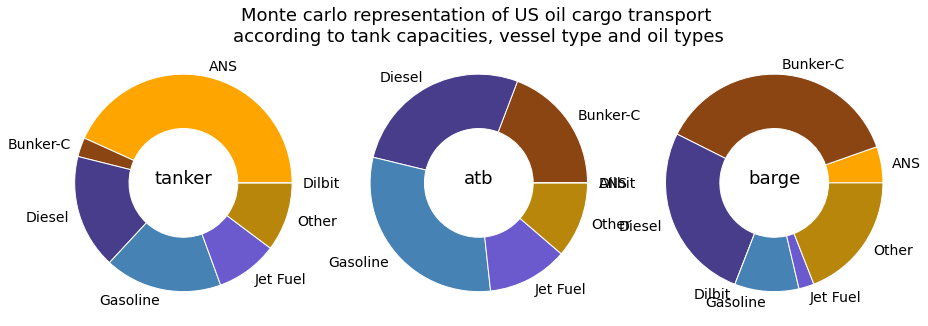

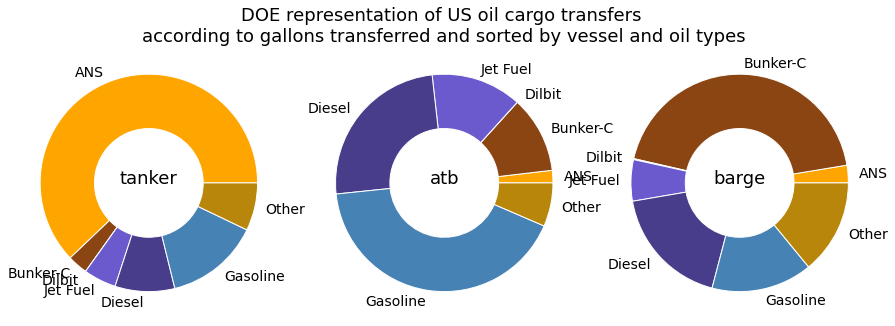

In [20]:
#--------------------------------------------------------------------------------
# Plot monte-carlo representation of US oil transport 
#--------------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge"]):
   
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('Monte carlo representation of US oil cargo transport \n'
            'according to tank capacities, vessel type and oil types'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        mc_allUS[vessel].values(), 
        labels = mc_allUS[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'monte_carlo_USoil')

#--------------------------------------------------------------------------------
## Plot department of ecology volume transfers from marine terminals by oil types
#--------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('DOE representation of US oil cargo transfers \n'
             'according to gallons transferred and sorted by '
             'vessel and oil types'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        combined_all[vessel].values(), 
        labels = combined_all[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil.png')

### Print: Percentages relating to US oil cargo transport 
(and differences shown in above graphic)

In [21]:
percent_test = calc_percent_difference(combined_all, mc_allUS)
percent_test

{'tanker':                      DOE  monte-carlo  DOE_minus_monte-carlo
 tanker export                                               
 ANS            62.122816    43.239078              18.883738
 Bunker-C        3.000172     2.854042               0.146129
 Dilbit          0.000000     0.000000               0.000000
 Jet Fuel        4.855479     9.196500              -4.341021
 Diesel          8.872796    17.011298              -8.138502
 Gasoline       14.036811    17.458912              -3.422100
 Other           7.111926    10.240170              -3.128243,
 'atb':                   DOE  monte-carlo  DOE_minus_monte-carlo
 atb export                                               
 ANS          1.854203     0.000000               1.854203
 Bunker-C    11.440769    19.212592              -7.771823
 Dilbit       0.000000     0.000000               0.000000
 Jet Fuel    13.490842    11.959730               1.531111
 Diesel      24.851243    26.998211              -2.146968
 Gasoline  

---
## Plot DOE representation of oil imports and combined imports/exports for the marine terminals in our study
---

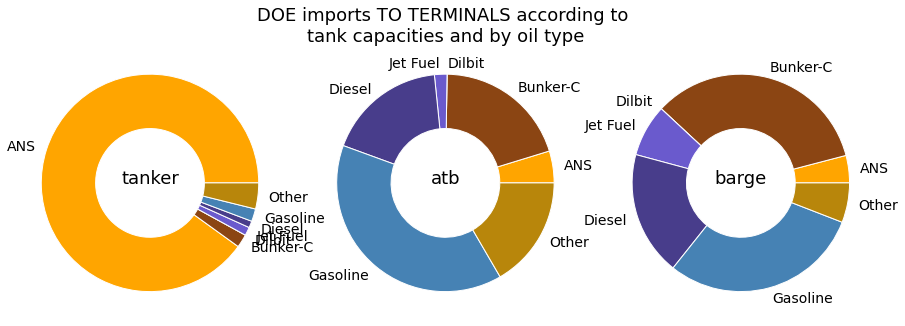

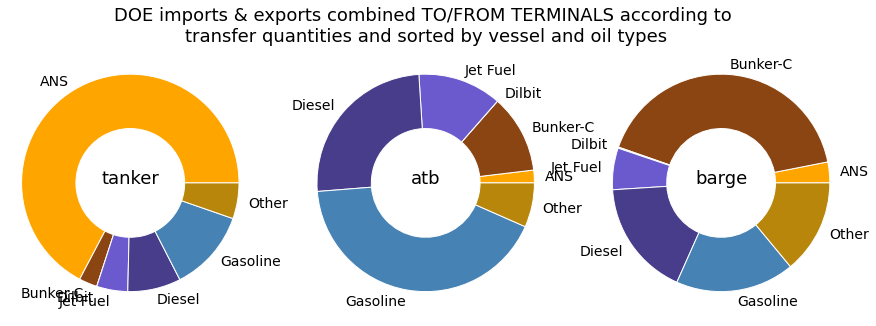

In [22]:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # calculate total cargo_capacity by vessel type and oil type
    net_import = imports[vessel].values()
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            ('DOE imports TO TERMINALS according to \n'
             'tank capacities and by oil type'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        net_import, 
        labels = imports[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil_imports_byterminals')

fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # calculate total cargo_capacity by vessel type and oil type
    net_combined = combined[vessel].values()
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
           ('DOE imports & exports combined TO/FROM TERMINALS according to \n'
             'transfer quantities and sorted by vessel and oil types'),
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        net_combined, 
        labels = combined[vessel].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil_combined_byterminals')

### NEXT: 
- Plot up all cargo transfers 
- Plot up all cargo oil in monte carlo (both terminal and non-terminal transfrrs)
- Plot up combined imports and exports to terminals
